In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

In [147]:
model = keras.Sequential([keras.layers.Dense(10, activation="relu", input_shape=(4,)),
                            keras.layers.Dense(10, activation="relu"),
                            keras.layers.Dense(3)])

In [148]:
model.compile(optimizer="sgd", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))
keras_hist2 = model.fit(x, y, epochs=200, verbose=0)

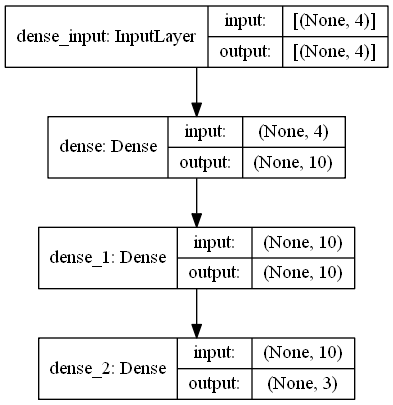

In [4]:
keras.utils.plot_model(model, show_shapes=True)

In [3]:
import os

train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
feature_names = column_names[:-1]
label_name = column_names[-1]

batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

train_dataset = train_dataset.map(pack_features_vector)

In [4]:
y = np.concatenate([y for x, y in train_dataset], axis=0)
x = np.concatenate([x for x, y in train_dataset], axis=0)

In [5]:
from evolvepy.integrations.tf_keras import TFKerasEvaluator, LossFitnessFunction

fitness_function = LossFitnessFunction(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), x=x, y=y)
evaluator = TFKerasEvaluator(model, fitness_function)


In [126]:
import evolvepy as ep

first = ep.generator.Layer()
combine = ep.generator.CombineLayer(ep.generator.selection.tournament, ep.generator.crossover.one_point)
mutation = ep.generator.mutation.NumericMutationLayer(ep.generator.mutation.sum_mutation, 1.0, 0.5, (-0.5, 0.5))
filter0 = ep.generator.FilterFirsts(143)
sort = ep.generator.Sort()
filter1 = ep.generator.FilterFirsts(7)
concat = ep.generator.Concatenate()

first.next = combine
combine.next = mutation
combine.next = filter0
filter0.next = concat

first.next = sort
sort.next = filter1
filter1.next = concat

generator = ep.generator.Generator(first_layer=first, last_layer=concat, descriptor=evaluator.descriptor)


In [127]:
mem_log = ep.callbacks.MemoryStoreLogger()
dyn_mut = ep.callbacks.DynamicMutation([mutation.name], patience=2, refinement_steps=20, refinement_patience=2, exploration_steps=10, exploration_patience=2, refinement_divider=3)

evolver = ep.Evolver(generator, evaluator, 150, [mem_log, dyn_mut])

In [128]:
hist, last_pop = evolver.evolve(200)

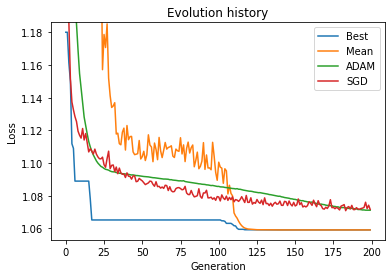

In [149]:
import matplotlib.pyplot as plt

plt.plot(-hist.max(axis=1))
plt.ylim(plt.ylim()[0] , plt.ylim()[1])

plt.plot(-hist.mean(axis=1))
plt.plot(keras_hist.history["loss"])
plt.plot(keras_hist2.history["loss"])

plt.xlabel("Generation")
plt.ylabel("Loss")
plt.title("Evolution history")
plt.legend(["Best", "Mean", "ADAM", "SGD"])

plt.show()

In [131]:
np.max(hist)

-1.059119462966919

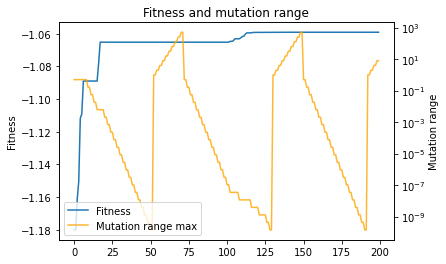

In [130]:
mutation_range_max = []

for log in mem_log.log:
    mutation_range_max.append(log["generator"][mutation.name+"/mutation_range_max"])

fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()

h1 = ax.plot(hist.max(axis=1), label="Fitness")[0]
ax.set_ylabel("Fitness")

h2 = ax2.plot(mutation_range_max, color="orange", label="Mutation range max", alpha=0.8)[0]
ax2.set_yscale("log")
ax2.set_ylabel("Mutation range")

plt.title("Fitness and mutation range")
plt.xlabel("Generation")
plt.legend(handles=[h1, h2])
plt.show()

In [38]:
hist = model.fit(x, y, epochs=200, verbose=0)

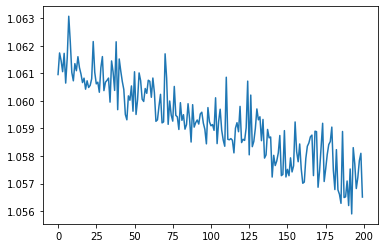

In [39]:
plt.plot(hist.history["loss"])

In [18]:
%timeit model.evaluate(train_dataset, verbose=0)

54.6 ms ± 495 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%timeit model.evaluate(x, y, verbose=0)

41.8 ms ± 606 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
def func():
    prediction = model.predict(x)
    fitness_function._loss(y, prediction)

%timeit func()

34.9 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
def func2():
    prediction = model(x)
    score = fitness_function._loss(y, prediction)
    np.array(score)

%timeit func2()

1.84 ms ± 57.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
import cProfile

cProfile.run("evolver.evolve(1)" , sort=1)

         276627 function calls (271798 primitive calls) in 0.667 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1400    0.240    0.000    0.242    0.000 constant_op.py:78(convert_to_eager_tensor)
     2500    0.191    0.000    0.191    0.000 {built-in method tensorflow.python._pywrap_tfe.TFE_Py_FastPathExecute}
      219    0.037    0.000    0.037    0.000 {built-in method numpy.array}
     8400    0.007    0.000    0.007    0.000 context.py:849(executing_eagerly)
  400/100    0.007    0.000    0.135    0.001 base_layer.py:926(__call__)
     2700    0.007    0.000    0.260    0.000 ops.py:1507(convert_to_tensor)
    33806    0.005    0.000    0.007    0.000 {built-in method builtins.isinstance}
     3300    0.004    0.000    0.005    0.000 dtypes.py:678(as_dtype)
     1000    0.004    0.000    0.132    0.000 math_ops.py:925(cast)
      600    0.004    0.000    0.269    0.000 resource_variable_ops.py:874(assign)
4400/2

In [91]:
features, labels = next(iter(train_dataset))

predict = model.predict(features)

In [66]:
true.shape

(1, 3)

In [60]:
predict.shape

(1, 3)

In [94]:
loss(y_true=labels, y_pred=predict)

<tf.Tensor: shape=(), dtype=float32, numpy=1.168009>

In [140]:
chromossome_sizes = []
chromossome_ranges = []
types = []
names = []

for weights in model.weights:
    chromossome_sizes.append(weights.shape.num_elements())
    chromossome_ranges.append((-1.0, 1.0))
    types.append(np.float32)
    names.append(weights.name)

from evolvepy.generator import Descriptor

descriptor = Descriptor(chromossome_sizes, chromossome_ranges, types, names)

In [141]:
descriptor._chromossome_sizes

array([ 40,  10, 100,  10,  30,   3])

In [123]:
import matplotlib.pyplot as plt

min = []
max = []

for weights in model.weights:
    min.append(np.min(weights))
    max.append(np.max(weights))

max

[0.6509609, 0.0, 0.54570127, 0.0, 0.6765835, 0.0]

In [ ]:
model.copy